# Test out aspects of frequency shifts and slice selection

In [30]:
%load_ext autoreload
%autoreload 2
import sys
import os
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import denmatsim.simseq
import numpy as np
import scipy.io
from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Load a real pulse 
matload = scipy.io.loadmat('hsinc_400_8750')
origpulse = matload['hsinc_400_8750_complexAmp']

# Interpolate it to fewer points to reduce calculation time 
pulse = np.interp(np.arange(0,origpulse.shape[0],5), np.arange(0,origpulse.shape[0]), origpulse[:,0])
pulse /= np.max(pulse)
pulse_time=3e-3
pulseSteps = pulse.shape[0]
shapedTimeStep = pulse_time/pulseSteps
print(f'Pulse time = {pulse_time}s, {pulseSteps} steps, {shapedTimeStep} step time')
pulseInt = np.sum(np.real(pulse))/pulseSteps
targetFA = 90
pulse_frq=0
pulse_pwr=500*(targetFA/180)*(1E-3/pulse_time)*(1/pulseInt)

Pulse time = 0.003s, 80 steps, 3.7500000000000003e-05 step time


In [31]:
parameterdict = {}
parameterdict.update({'centralShift':0})
parameterdict.update({'B0':7})

parameterdict.update({'Rx_LW':2})
parameterdict.update({'Rx_SW':6000})
parameterdict.update({'Rx_Points':4096})
parameterdict.update({'Rx_Phase':0})
       
parameterdict.update({'x':(-25,25)})
parameterdict.update({'y':(-0,0)})
parameterdict.update({'z':(-0,0)})
parameterdict.update({'resolution':(25,1,1)})
parameterdict.update({'spaceUnits':'mm'})
    
parameterdict.update({'CoherenceFilter':[-1,]})

pulse1 = {}
pulse1.update({'cmplx':pulse_pwr*pulse})
pulse1.update({'time':pulse_time})
pulse1.update({'grad':[0.00343,0,0]})
pulse1.update({'frequencyOffset':0.0})
pulse1.update({'phaseOffset':0.0})
RFList = [pulse1]
parameterdict.update({'RF':RFList})

rephaseMat = np.zeros((1,3))
rephaseMat[0,0] = -0.00343*pulse_time/2
print(rephaseMat)
parameterdict.update({'rephaseAreas':rephaseMat})
parameterdict.update({'delays':np.array([1.0E-3])})

parameterdict.update({'spatiallyResolve':True})
parameterdict.update({'method':'interleaved'})

spinsys = {'shifts':np.array([0.0,-2.0, 2.0]),'j':np.array([[0,0,0],[0,0,0],[0,0,0]])}

FIDsim1D,ax,_ = denmatsim.simseq.simseq(spinsys,parameterdict)

[[-5.145e-06  0.000e+00  0.000e+00]]
Simulation running using mode interleaved. Axis order = [0].


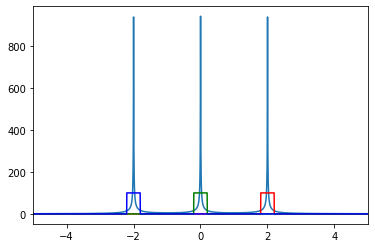

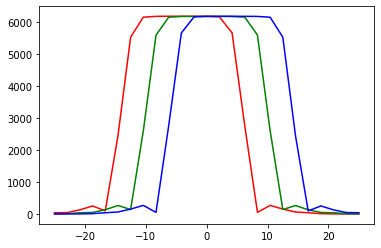

In [32]:
spec1DTest = np.fft.fftshift(np.fft.fft(FIDsim1D,axis=0),axes=0)

ppmIndicies = []
ppmIndicies.append((ax['ppm']<2.2)&(ax['ppm']>1.8))
ppmIndicies.append((ax['ppm']<0.2)&(ax['ppm']>-0.2))
ppmIndicies.append((ax['ppm']<-1.8)&(ax['ppm']>-2.2))

plt.plot(ax['ppm'],np.abs(spec1DTest[:,12,0,0]))
plt.plot(ax['ppm'],ppmIndicies[0]*100,'r')
plt.plot(ax['ppm'],ppmIndicies[1]*100,'g')
plt.plot(ax['ppm'],ppmIndicies[2]*100,'b')
plt.xlim([-5,5])
plt.show()

peak1Sum = np.sum(np.abs(spec1DTest)*ppmIndicies[0][:,None,None,None],axis=0)
peak2Sum = np.sum(np.abs(spec1DTest)*ppmIndicies[1][:,None,None,None],axis=0)
peak3Sum = np.sum(np.abs(spec1DTest)*ppmIndicies[2][:,None,None,None],axis=0)

pos = np.linspace(parameterdict['x'][0],parameterdict['x'][1],parameterdict['resolution'][0])
plt.plot(pos,peak1Sum[:,0,0],'r')
plt.plot(pos,peak2Sum[:,0,0],'g')
plt.plot(pos,peak3Sum[:,0,0],'b')

plt.show()

Simulation running using mode interleaved. Axis order = [0].


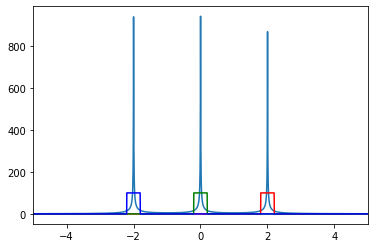

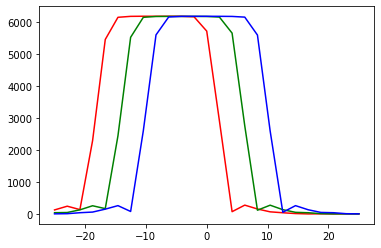

In [33]:
# Shift pulse centre to -2 ppm
parameterdict2 = parameterdict
parameterdict2['RF'][0]['frequencyOffset'] = 7*42.5774*-2
FIDsim1D_shift,ax,_ = denmatsim.simseq.simseq(spinsys,parameterdict2)

spec1DTest = np.fft.fftshift(np.fft.fft(FIDsim1D_shift,axis=0),axes=0)

ppmIndicies = []
ppmIndicies.append((ax['ppm']<2.2)&(ax['ppm']>1.8))
ppmIndicies.append((ax['ppm']<0.2)&(ax['ppm']>-0.2))
ppmIndicies.append((ax['ppm']<-1.8)&(ax['ppm']>-2.2))

plt.plot(ax['ppm'],np.abs(spec1DTest[:,12,0,0]))
plt.plot(ax['ppm'],ppmIndicies[0]*100,'r')
plt.plot(ax['ppm'],ppmIndicies[1]*100,'g')
plt.plot(ax['ppm'],ppmIndicies[2]*100,'b')
plt.xlim([-5,5])
plt.show()

peak1Sum = np.sum(np.abs(spec1DTest)*ppmIndicies[0][:,None,None,None],axis=0)
peak2Sum = np.sum(np.abs(spec1DTest)*ppmIndicies[1][:,None,None,None],axis=0)
peak3Sum = np.sum(np.abs(spec1DTest)*ppmIndicies[2][:,None,None,None],axis=0)

pos = np.linspace(parameterdict['x'][0],parameterdict['x'][1],parameterdict['resolution'][0])
plt.plot(pos,peak1Sum[:,0,0],'r')
plt.plot(pos,peak2Sum[:,0,0],'g')
plt.plot(pos,peak3Sum[:,0,0],'b')

plt.show()

In [36]:
# Shift rx centre to 4.65 but keep pulse centre at -2 ppm
parameterdict3 = parameterdict
parameterdict3['centralShift'] = 4.65
parameterdict3['RF'][0]['frequencyOffset'] = 7.0*42.5774*(-2.0+-4.65)
FIDsim1D_shift,ax,_ = denmatsim.simseq.simseq(spinsys,parameterdict3)

spec1DTest = np.fft.fftshift(np.fft.fft(FIDsim1D_shift,axis=0),axes=0)

ppmIndicies = []
ppmIndicies.append((ax['ppm']<(2.2-4.65))&(ax['ppm']>(1.8-4.65)))
ppmIndicies.append((ax['ppm']<(0.2-4.65))&(ax['ppm']>(-0.2-4.65)))
ppmIndicies.append((ax['ppm']<(-1.8-4.65))&(ax['ppm']>(-2.2-4.65)))

plt.plot(ax['ppm'],np.abs(spec1DTest[:,12,0,0]))
plt.plot(ax['ppm'],ppmIndicies[0]*100,'r')
plt.plot(ax['ppm'],ppmIndicies[1]*100,'g')
plt.plot(ax['ppm'],ppmIndicies[2]*100,'b')
plt.xlim([-10,5])
plt.show()

peak1Sum = np.sum(np.abs(spec1DTest)*ppmIndicies[0][:,None,None,None],axis=0)
peak2Sum = np.sum(np.abs(spec1DTest)*ppmIndicies[1][:,None,None,None],axis=0)
peak3Sum = np.sum(np.abs(spec1DTest)*ppmIndicies[2][:,None,None,None],axis=0)

pos = np.linspace(parameterdict3['x'][0],parameterdict3['x'][1],parameterdict3['resolution'][0])
plt.plot(pos,peak1Sum[:,0,0],'r')
plt.plot(pos,peak2Sum[:,0,0],'g')
plt.plot(pos,peak3Sum[:,0,0],'b')

plt.show()

Simulation running using mode interleaved. Axis order = [0].
